In [1]:
import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

import os

import pickle

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Flatten, Dense
from keras.regularizers import l2

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using MXNet backend


In [17]:
cd Wiki_comment_comp/

[Errno 2] No such file or directory: 'Wiki_comment_comp/'
/home/ubuntu/Wiki_comment_comp


In [3]:
jigsaw_train_data = pd.read_csv('train.csv.zip')
jigsaw_test_data = pd.read_csv('test.csv.zip')
jigsaw_test_label_data = pd.read_csv('test_labels.csv.zip')

In [4]:
binary_df = jigsaw_train_data[['comment_text','toxic']]

In [5]:
texts = []
labels = []

for comment in binary_df['comment_text']:
    texts.append(comment)
    
for flag in binary_df['toxic']:
    labels.append(flag)

In [6]:
training_samples = 100000
validation_samples = binary_df.shape[0] - training_samples
max_words = 50000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [7]:
maxLength = max(len(x) for x in sequences)
minLength = min(len(x) for x in sequences)
print(maxLength)
print(minLength)

1401
0


In [8]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 210337 unique tokens.


In [9]:
maxlen = 500
data = pad_sequences(sequences, maxlen=maxlen)
len(data[0]) ## sequence 0 has been reduced to len 200 from ~500

500

In [10]:
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label0 tensor:', labels.shape)

Shape of data tensor: (159571, 500)
Shape of label0 tensor: (159571,)


In [11]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [51]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [13]:
glove_dir = '/home/ubuntu'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [15]:
## Build basic fully connected model

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          5000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6400128   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 11,400,257
Trainable params: 11,400,257
Non-trainable params: 0
_________________________________________________________________


In [16]:
## Here we load the glove matrix into layer 0

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [17]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 2500,
                   validation_data=[x_val, y_val])
model.save_weights('pre_trained_glove_model.h5')

Train on 100000 samples, validate on 59571 samples
Epoch 1/10


/home/ubuntu/anaconda3/envs/aws_neuron_mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:411: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0004). Is this intended?
  force_init=force_init)


100000/100000 [==============================] - 49s 489us/step - loss: 0.3618 - acc: 0.8995 - val_loss: 0.2095 - val_acc: 0.9070
Epoch 2/10
100000/100000 [==============================] - 41s 410us/step - loss: 0.2109 - acc: 0.9245 - val_loss: 0.1982 - val_acc: 0.9272
Epoch 3/10
100000/100000 [==============================] - 41s 412us/step - loss: 0.1861 - acc: 0.9330 - val_loss: 0.1953 - val_acc: 0.9289
Epoch 4/10
100000/100000 [==============================] - 41s 414us/step - loss: 0.1721 - acc: 0.9369 - val_loss: 0.1882 - val_acc: 0.9314
Epoch 5/10
100000/100000 [==============================] - 41s 412us/step - loss: 0.1637 - acc: 0.9400 - val_loss: 0.1774 - val_acc: 0.9357
Epoch 6/10
100000/100000 [==============================] - 41s 406us/step - loss: 0.1530 - acc: 0.9425 - val_loss: 0.1784 - val_acc: 0.9334
Epoch 7/10
100000/100000 [==============================] - 41s 413us/step - loss: 0.1480 - acc: 0.9453 - val_loss: 0.1722 - val_acc: 0.9362
Epoch 8/10
100000/100000

In [18]:
predictions = model.predict(x_val)

pred_ls = []
for i in predictions:
    if i > .5:
        pred_ls.append(1)
    else:
        pred_ls.append(0)

In [19]:
matrix = confusion_matrix(y_val, pred_ls)
print(classification_report(y_val, pred_ls))
print(matrix)

              precision    recall  f1-score   support

           0       0.96      0.95      0.96     53806
           1       0.61      0.67      0.64      5765

    accuracy                           0.93     59571
   macro avg       0.79      0.81      0.80     59571
weighted avg       0.93      0.93      0.93     59571

[[51302  2504]
 [ 1914  3851]]


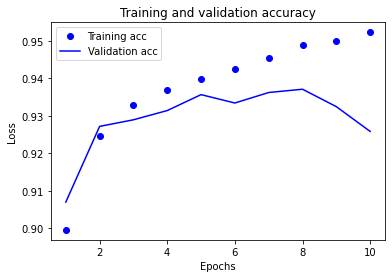

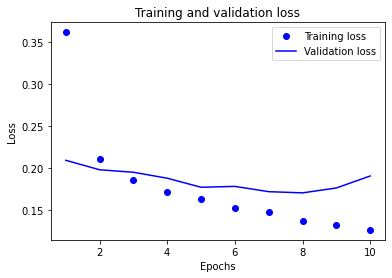

In [20]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
## Let's trty without a pretrained embedding ie create an embedding from the dataset

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
                activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 100)          5000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               6400128   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 11,400,257
Trainable params: 11,400,257
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 2500,
                   validation_data=[x_val, y_val])
model.save_weights('pre_trained_glove_model.h5')

Train on 60000 samples, validate on 0 samples
Epoch 1/10


/home/ubuntu/anaconda3/envs/aws_neuron_mxnet_p36/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:411: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.0004). Is this intended?
  force_init=force_init)


60000/60000 [==============================] - 56s 931us/step - loss: 0.6019 - acc: 0.7946
Epoch 2/10
60000/60000 [==============================] - 58s 969us/step - loss: 0.5233 - acc: 0.7970
Epoch 3/10
12500/60000 [=====>........................] - ETA: 45s - loss: 0.5044 - acc: 0.7964

KeyboardInterrupt: 

In [21]:
predictions = model.predict(x_val)

pred_ls = []
for i in predictions:
    if i > .5:
        pred_ls.append(1)
    else:
        pred_ls.append(0)
        
matrix = confusion_matrix(y_val, pred_ls)
print(classification_report(y_val, pred_ls))
print(matrix)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      4510
           1       0.87      0.38      0.53       490

    accuracy                           0.93      5000
   macro avg       0.90      0.69      0.75      5000
weighted avg       0.93      0.93      0.92      5000

[[4481   29]
 [ 304  186]]


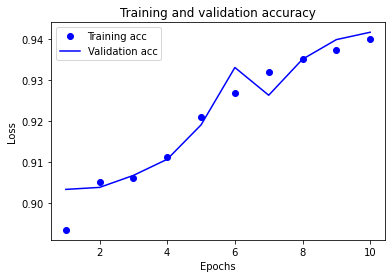

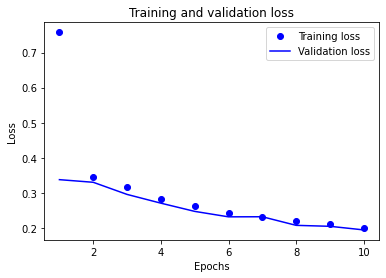

In [24]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
## This version is performing reasonably well but lets leverage an RNN now to see if we can improve on this.

## Given the better performing custom embedding, we'll use this approach here.

## We're also going to reduce the train and validation set sizes to speed up the process.

from keras.layers import SimpleRNN

In [67]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
#model.add(SimpleRNN(256, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 500, 100)          5000000   
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 64)                10560     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 5,010,625
Trainable params: 5,010,625
Non-trainable params: 0
_________________________________________________________________


In [68]:
## Reduce the the data input volume

training_samples = 30000
validation_samples = 5000

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [69]:
## Check distribution of labels

list(y_train).count(0), list(y_train).count(1), list(y_val).count(0), list(y_val).count(1)

(27167, 2833, 4510, 490)

Article on reduced loss without increase in accuracy - https://stackoverflow.com/questions/43499199/tensorflow-loss-decreasing-but-accuracy-stable

In [71]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs = 10,
                   batch_size = 2500,
                   validation_data=[x_val, y_val])

Train on 30000 samples, validate on 5000 samples
Epoch 1/10
30000/30000 [==============================] - 152s 5ms/step - loss: 0.4937 - acc: 0.9056 - val_loss: 0.3607 - val_acc: 0.9020
Epoch 2/10
30000/30000 [==============================] - 117s 4ms/step - loss: 0.2944 - acc: 0.9062 - val_loss: 0.2663 - val_acc: 0.9084
Epoch 3/10
30000/30000 [==============================] - 69s 2ms/step - loss: 0.2383 - acc: 0.9177 - val_loss: 0.2826 - val_acc: 0.9240
Epoch 4/10
30000/30000 [==============================] - 110s 4ms/step - loss: 0.2067 - acc: 0.9327 - val_loss: 0.2010 - val_acc: 0.9318
Epoch 5/10
30000/30000 [==============================] - 82s 3ms/step - loss: 0.1859 - acc: 0.9397 - val_loss: 0.1909 - val_acc: 0.9346
Epoch 6/10
30000/30000 [==============================] - 82s 3ms/step - loss: 0.1601 - acc: 0.9470 - val_loss: 0.2023 - val_acc: 0.9322
Epoch 7/10
30000/30000 [==============================] - 72s 2ms/step - loss: 0.1488 - acc: 0.9500 - val_loss: 0.1851 - val_a

In [72]:
predictions = model.predict(x_val)

pred_ls = []
for i in predictions:
    if i > .5:
        pred_ls.append(1)
    else:
        pred_ls.append(0)
        
matrix = confusion_matrix(y_val, pred_ls)
print(classification_report(y_val, pred_ls))
print(matrix)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4510
           1       0.83      0.57      0.67       490

    accuracy                           0.95      5000
   macro avg       0.89      0.78      0.82      5000
weighted avg       0.94      0.95      0.94      5000

[[4452   58]
 [ 213  277]]


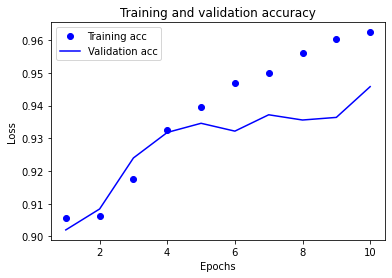

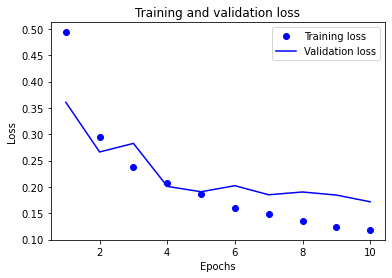

In [73]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
#model.add(SimpleRNN(256, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(1, activation='sigmoid'))
model.summary()